# Cars classification
### with ResNet-50 transfer learning (14 classes)

Data based on <a href='http://ai.stanford.edu/~jkrause/cars/car_dataset.html'>Stanford Cars Dataset</a>

Data was cleaned

In [ ]:
# Mount drive (for Google Colab)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

In [ ]:
base_path = 'drive/MyDrive/Machine Learning/Cars classification/'
train_path = os.path.join(base_path, 'train_data')
test_path = os.path.join(base_path, 'cars_test')
meta_path = os.path.join(base_path, 'meta')

In [54]:
# Data loading and processing
data_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # from ImageNet
    ])

image_dataset = datasets.ImageFolder(train_path, data_transform)

train_set, val_set = torch.utils.data.random_split(image_dataset, [4041, 1100])

image_datasets = {'train': train_set, 'val': val_set}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [28]:
print(device.type)

cuda


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


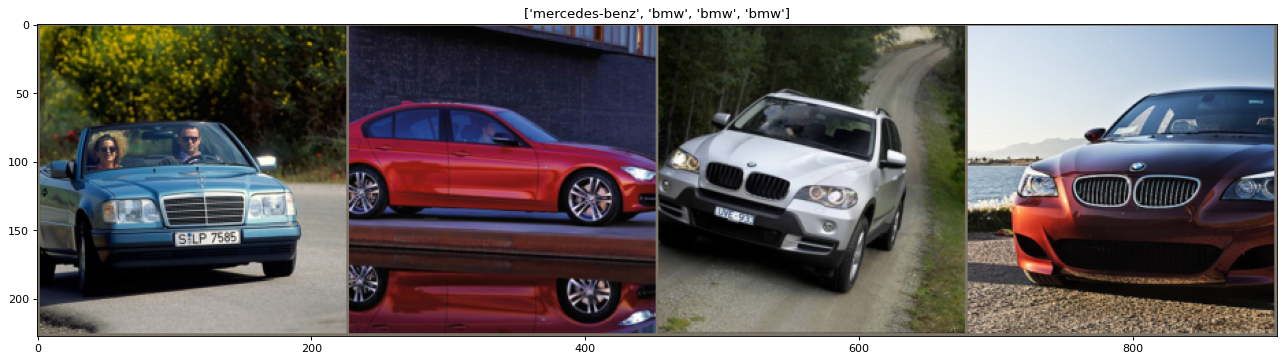

In [29]:
def imshow(inp, title=None):
    # ImShow for Tensor
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

plt.figure(figsize=(20, 10), dpi=80)
imshow(out, title=[class_names[x] for x in classes])

In [30]:
print('Our classes:', ', '.join(class_names))
num_classes = len(class_names)
print('Number of classes:', num_classes)

Our classes: acura, audi, bentley, bmw, chevrolet, chrysler, dodge, ferrari, ford, honda, hyundai, jeep, lamborghini, mercedes-benz
Number of classes: 14


In [31]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [97]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                #ax.set_title(f'predicted: {class_names[preds[j]]}')
                plt.figure(figsize=(3, 3))
                imshow(inputs.cpu().data[j])
                print(f'predicted: {class_names[preds[j]]}')

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [33]:
# Initialize ResNet50

model_ft = models.resnet50(pretrained=True)

In [36]:
# Finetuning ResNet50

num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 14.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, num_classes)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.005)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

In [55]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=5) # A lot more epochs in total

Epoch 0/4
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6349 Acc: 0.8248
val Loss: 0.5020 Acc: 0.8600

Epoch 1/4
----------
train Loss: 0.6392 Acc: 0.8194
val Loss: 0.4942 Acc: 0.8645

Epoch 2/4
----------
train Loss: 0.6321 Acc: 0.8206
val Loss: 0.4860 Acc: 0.8618

Epoch 3/4
----------
train Loss: 0.6365 Acc: 0.8238
val Loss: 0.4877 Acc: 0.8636

Epoch 4/4
----------
train Loss: 0.6265 Acc: 0.8268
val Loss: 0.4919 Acc: 0.8618

Training complete in 8m 48s
Best val Acc: 0.864545


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


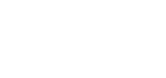

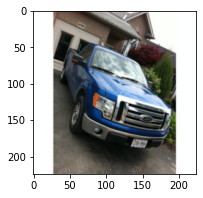

predicted: ford


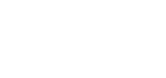

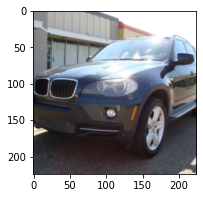

predicted: bmw


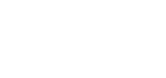

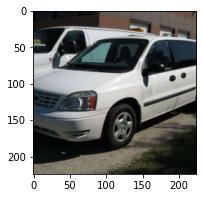

predicted: ford


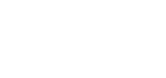

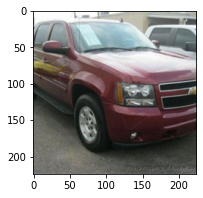

predicted: chevrolet


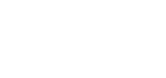

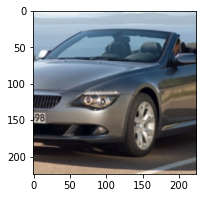

predicted: bmw


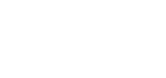

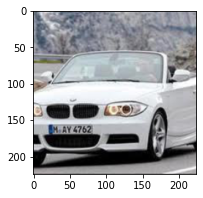

predicted: bmw


In [106]:
visualize_model(model_ft)

In [117]:
def evaluate_model(model):
    model.eval()   # Set model to evaluate mode
    running_corrects = 0
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    acc = running_corrects.double() / dataset_sizes['val']
    print(f'Validation accuracy: {100*acc:.2f}%')

In [118]:
evaluate_model(model_ft)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Validation accuracy: 86.45%


In [119]:
torch.save(model_ft.state_dict(), os.path.join(base_path, 'resnet_model_stable'))

In [43]:
model_ft.load_state_dict(torch.load(os.path.join(base_path, 'resnet_model_stable')))

model_ft = model_ft.to(device)